In [39]:
import h5py
import numpy as np

tmp_data = "/home/memmelma/Projects/problem_reduction/data/pick_and_place_2500_3_objs_va_vel_004_ee_hamster.hdf5"

with h5py.File(tmp_data, "r") as file:
    for dk in file["data"].keys():
        video = file["data"][dk]["obs"]["rgb"][:]
        lang_embed = file["data"][dk]["obs"]["lang_instr"][:]
        break

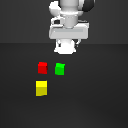

In [5]:
from PIL import Image
Image.fromarray(video[0])

In [ ]:
# compute all possible lang instructions

from problem_reduction.threedda.text_embed import CLIPTextEmbedder
clip_embedder = CLIPTextEmbedder(device="cuda")

lang_instrs = {}
colors = ["red", "green", "yellow", "blue"]
for c0 in colors:
    for c1 in colors:
        lang_instr = f"put the {c0} cube on the {c1} cube"
        lang_instrs[lang_instr] = clip_embedder.embed_instruction(lang_instr).numpy()

LANG put the red cube on the yellow cube 
DIST 0.0001172232 
DINO red cube. yellow cube. gripper.


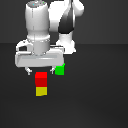

In [66]:
def get_closest_lang_instr(lang_embed, lang_instrs):
    min_distance = np.inf
    for k, v in lang_instrs.items():
        # if np.sum(lang_embed[0] - v):
            # print(k)
        distance = np.abs(np.sum(lang_embed[0] - v))
        if distance < min_distance:
            min_distance = distance
            best_lang_instr = k

    return best_lang_instr, min_distance

lang_instr, distance = get_closest_lang_instr(lang_embed[0], lang_instrs)
objects = lang_instr.replace("put the ", "").split(" on the ") + ["gripper."]
dino_instr = ". ".join(objects)

print("LANG", lang_instr, "\nDIST", distance, "\nDINO", dino_instr)
Image.fromarray(video[-1])

In [6]:
import torch, numpy as np
from PIL import Image
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    Sam2Processor, Sam2Model,
    Sam2VideoProcessor, Sam2VideoModel, infer_device
)

In [93]:
def masks_from_text(image: Image.Image,
                    text: str,
                    dino_id="IDEA-Research/grounding-dino-tiny",
                    sam2_id="facebook/sam2.1-hiera-small",
                    box_thresh=0.35, text_thresh=0.25):
    device = infer_device()

    # GroundingDINO: zero-shot boxes from language
    dino_proc = AutoProcessor.from_pretrained(dino_id)
    dino = AutoModelForZeroShotObjectDetection.from_pretrained(dino_id).to(device)
    din = dino_proc(images=image, text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        dout = dino(**din)
    det = dino_proc.post_process_grounded_object_detection(
        dout, din.input_ids, threshold=box_thresh, text_threshold=text_thresh,
        target_sizes=[image.size[::-1]]
    )[0]  # -> dict with "boxes" (xyxy), "scores", "labels"  [H,W] scale  (HF docs)
    if det["boxes"].numel() == 0:
        return None  # nothing found

    # SAM2 image: convert boxes → masks
    s2_proc = Sam2Processor.from_pretrained(sam2_id)
    s2 = Sam2Model.from_pretrained(sam2_id).to(device)
    input_boxes = [det["boxes"].tolist()]                    # [image][objects][4]
    sin = s2_proc(images=image, input_boxes=input_boxes, return_tensors="pt").to(device)
    with torch.no_grad():
        sout = s2(**sin, multimask_output=False)             # 1 mask per object
    masks = s2_proc.post_process_masks(sout.pred_masks.cpu(), sin["original_sizes"])[0]
    # post_process returns (1, N, H, W) for single image; squeeze batch
    if masks.dim() == 4 and masks.size(0) == 1:
        masks = masks[0]
    masks = (masks > 0.5).to(torch.bool)                     # binarize for video prompts

    # pack results
    return {
        "boxes_xyxy": det["boxes"].cpu(),    # (N,4) on original image scale
        "scores": det["scores"].cpu(),       # (N,)
        "labels": det["labels"],             # list[str] (may be phrases)
        "masks": masks,                      # (N,H,W) bool
        "orig_hw": tuple(sin["original_sizes"][0].tolist())  # (H,W)
    }

def track_masks_stream(frames, init_result, sam2_id="facebook/sam2.1-hiera-small"):
    """
    frames: iterable of PIL.Image frames, frame 0 must match the image used to create init_result
    init_result: output dict from masks_from_text()
    yields (t, masks_t) where masks_t is a (N,H,W) bool torch.Tensor for frame t
    """
    device = infer_device()
    vproc = Sam2VideoProcessor.from_pretrained(sam2_id)
    vmodel = Sam2VideoModel.from_pretrained(sam2_id).to(device, dtype=torch.bfloat16
                                                        if torch.cuda.is_available() else torch.float32)

    # Streaming session (no preloaded video)
    session = vproc.init_video_session(inference_device=device,
                                       dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32)

    obj_ids = list(range(1, init_result["masks"].shape[0] + 1))  # stable IDs 1..N
    for t, frame in enumerate(frames):
        vin = vproc(images=frame, return_tensors="pt")
        if t == 0:
            # prompt the tracker with binary masks on frame 0
            vproc.add_inputs_to_inference_session(
                inference_session=session,
                frame_idx=0,
                obj_ids=obj_ids,
                input_masks=[m.numpy() for m in init_result["masks"].cpu()],  # list of (H,W)
                original_size=tuple(vin.original_sizes[0])  # required in streaming mode
            )
            out = vmodel(inference_session=session, frame=vin.pixel_values[0].to(vmodel.device))
        else:
            out = vmodel(inference_session=session, frame=vin.pixel_values[0].to(vmodel.device))

        masks_t = vproc.post_process_masks(
            [out.pred_masks], original_sizes=vin.original_sizes, binarize=True
        )[0]  # -> (N,H,W)
        yield t, masks_t.to(torch.bool)


import numpy as np

def apply_masks_to_frames(frames, masks_list, darken_background=False):
    """
    frames: list of PIL.Image or np.ndarray [H,W,3]
    masks_list: list of torch.BoolTensor or np.ndarray [N,H,W]
    returns: list of np.ndarray frames with masks applied
    """
    out_frames = []
    for frame, masks in zip(frames, masks_list):
        if not isinstance(frame, np.ndarray):
            frame = np.array(frame)
        if hasattr(masks, "numpy"):  # torch.Tensor
            masks = masks.cpu().numpy()
        masks = masks.squeeze(1)
        if masks.ndim == 3:  # multiple objects -> combine
            mask = np.any(masks, axis=0)
        else:
            mask = masks

        mask3 = np.repeat(mask[..., None], 3, axis=-1)
        out = frame * mask3

        out_frames.append(out.astype(np.uint8))
    return out_frames


init = masks_from_text(Image.fromarray(video[0]), dino_instr)

masks_list = []
for t, masks in track_masks_stream(video, init):
    print(f"t={t} | tracked {masks.shape[0]} objects, mask size={tuple(masks.shape[-2:])}")
    masks_list.append(masks)


video_masked = apply_masks_to_frames(video, masks_list)

import imageio
imageio.mimsave("video_masked.mp4", video_masked)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 24600.02it/s]
You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.
Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 41665.27it/s]


t=0 | tracked 4 objects, mask size=(128, 128)
t=1 | tracked 4 objects, mask size=(128, 128)
t=2 | tracked 4 objects, mask size=(128, 128)
t=3 | tracked 4 objects, mask size=(128, 128)
t=4 | tracked 4 objects, mask size=(128, 128)
t=5 | tracked 4 objects, mask size=(128, 128)
t=6 | tracked 4 objects, mask size=(128, 128)
t=7 | tracked 4 objects, mask size=(128, 128)
t=8 | tracked 4 objects, mask size=(128, 128)
t=9 | tracked 4 objects, mask size=(128, 128)
t=10 | tracked 4 objects, mask size=(128, 128)
t=11 | tracked 4 objects, mask size=(128, 128)
t=12 | tracked 4 objects, mask size=(128, 128)
t=13 | tracked 4 objects, mask size=(128, 128)
t=14 | tracked 4 objects, mask size=(128, 128)
t=15 | tracked 4 objects, mask size=(128, 128)
t=16 | tracked 4 objects, mask size=(128, 128)
t=17 | tracked 4 objects, mask size=(128, 128)
t=18 | tracked 4 objects, mask size=(128, 128)
t=19 | tracked 4 objects, mask size=(128, 128)
t=20 | tracked 4 objects, mask size=(128, 128)
t=21 | tracked 4 object

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 8050.49it/s]
/home/memmelma/miniforge3/envs/pr_3dda_sam/lib/python3.10/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)
Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 35394.97it/s]
You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.
100%|██████████| 50/50 [00:04<00:00, 12.25it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environ

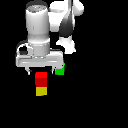

In [96]:
import torch
from PIL import Image
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    Sam2Processor, Sam2Model,
    Sam2VideoProcessor, Sam2VideoModel, infer_device
)

class GroundedSam2Tracker:
    def __init__(self,
                 init_frame: Image.Image,
                 text: str,
                 dino_id="IDEA-Research/grounding-dino-tiny",
                 sam2_id="facebook/sam2.1-hiera-small",
                 box_thresh=0.35, text_thresh=0.25):
        """
        Runs: text→boxes (GroundingDINO) → masks (SAM2 image) → seeds SAM2 Video session.
        """
        self.device = infer_device()

        # ---- GroundingDINO: language → boxes on init_frame ----
        self.dino_proc = AutoProcessor.from_pretrained(dino_id)
        self.dino = AutoModelForZeroShotObjectDetection.from_pretrained(dino_id).to(self.device)
        din = self.dino_proc(images=init_frame, text=text, return_tensors="pt").to(self.device)
        with torch.no_grad():
            dout = self.dino(**din)
        det = self.dino_proc.post_process_grounded_object_detection(
            dout, din.input_ids, threshold=box_thresh, text_threshold=text_thresh,
            target_sizes=[init_frame.size[::-1]]
        )[0]
        if det["boxes"].numel() == 0:
            raise ValueError("No detections above thresholds on the init frame.")

        # Stash detections
        self.boxes_xyxy = det["boxes"].detach().cpu()   # (N,4)
        self.scores = det["scores"].detach().cpu()      # (N,)
        self.labels = det["labels"]                     # list[str]

        # ---- SAM2 image: boxes → masks on init_frame ----
        self.s2_proc = Sam2Processor.from_pretrained(sam2_id)
        self.s2 = Sam2Model.from_pretrained(sam2_id).to(self.device)
        input_boxes = [self.boxes_xyxy.tolist()]  # [image][objects][4]
        sin = self.s2_proc(images=init_frame, input_boxes=input_boxes, return_tensors="pt").to(self.device)
        with torch.no_grad():
            sout = self.s2(**sin, multimask_output=False)
        masks = self.s2_proc.post_process_masks(sout.pred_masks.cpu(), sin["original_sizes"])[0]
        if masks.dim() == 4 and masks.size(0) == 1:
            masks = masks[0]
        self.init_masks = (masks > 0.5).to(torch.bool)  # (N,H,W)

        # ---- SAM2 Video: create streaming session and seed with init masks ----
        self.vproc = Sam2VideoProcessor.from_pretrained(sam2_id)
        self.vmodel = Sam2VideoModel.from_pretrained(sam2_id).to(
            self.device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
        )
        self.session = self.vproc.init_video_session(
            inference_device=self.device,
            dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
        )
        self.obj_ids = list(range(1, self.init_masks.shape[0] + 1))
        vin0 = self.vproc(images=init_frame, return_tensors="pt")
        self.vproc.add_inputs_to_inference_session(
            inference_session=self.session,
            frame_idx=0,
            obj_ids=self.obj_ids,
            input_masks=[m.numpy() for m in self.init_masks.cpu()],  # list of (H,W)
            original_size=tuple(vin0.original_sizes[0])
        )
        with torch.no_grad():
            out0 = self.vmodel(inference_session=self.session,
                               frame=vin0.pixel_values[0].to(self.vmodel.device))
        masks0 = self.vproc.post_process_masks([out0.pred_masks],
                                               original_sizes=vin0.original_sizes,
                                               binarize=True)[0]
        self.frame_idx = 1
        self.last_masks = masks0.to(torch.bool)

    def apply_masks_to_frames(self, frames, masks_list):
        """
        frames: list of PIL.Image or np.ndarray [H,W,3]
        masks_list: list of torch.BoolTensor or np.ndarray [N,H,W]
        returns: list of np.ndarray frames with masks applied
        """
        out_frames = []
        for frame, masks in zip(frames, masks_list):
            if not isinstance(frame, np.ndarray):
                frame = np.array(frame)
            if hasattr(masks, "numpy"):  # torch.Tensor
                masks = masks.cpu().numpy()
            masks = masks.squeeze(1)
            if masks.ndim == 3:  # multiple objects -> combine
                mask = np.any(masks, axis=0)
            else:
                mask = masks

            mask3 = np.repeat(mask[..., None], 3, axis=-1)
            out = frame * mask3

            out_frames.append(out.astype(np.uint8))
        return out_frames

    @torch.no_grad()
    def step(self, frame: Image.Image):
        """
        Push one new frame; returns (frame_idx, masks) where masks is (N,H,W) bool tensor.
        """
        vin = self.vproc(images=frame, return_tensors="pt")
        out = self.vmodel(inference_session=self.session,
                          frame=vin.pixel_values[0].to(self.vmodel.device))
        masks_t = self.vproc.post_process_masks([out.pred_masks],
                                                original_sizes=vin.original_sizes,
                                                binarize=True)[0].to(torch.bool)
        idx = self.frame_idx
        self.frame_idx += 1
        self.last_masks = masks_t
        return idx, masks_t

from tqdm import tqdm

tracker = GroundedSam2Tracker(init_frame=Image.fromarray(video[0]), text=dino_instr)

masks_list = []
for f in tqdm(video[1:]):
    t, masks = tracker.step(Image.fromarray(f))
    masks_list.append(masks)

video_masked = tracker.apply_masks_to_frames(video, masks_list)

imageio.mimsave("video_masked.mp4", video_masked)

Image.fromarray(video_masked[-1])

In [ ]:
# GroundingDINO -> open-vocab masks

# SAM2 -> track masks over video

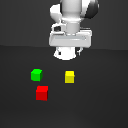

In [2]:
from PIL import Image
import h5py

path ="/home/memmelma/Projects/problem_reduction/data/pick_and_place_2500_3_objs_va_vel_004_ee_exp_mask.hdf5"
with h5py.File(path, "r") as file:
    dk = list(file["data"].keys())[-1]
    rgb = file["data"][dk]["obs"]["rgb"][:]
    
Image.fromarray(rgb[0])


put the red cube on the yellow cube


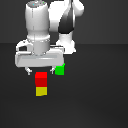

In [50]:
Image.fromarray(video[-1])

In [ ]:
lang_embed[0] == 

array([[[ 0.33928597,  0.11646014,  0.10195107, ...,  0.24677396,
          0.5906364 ,  0.10129976],
        [ 2.7050977 , -1.5918036 ,  0.10446533, ...,  0.08746468,
          0.41102052, -0.56180817],
        [ 1.3162001 , -1.4527766 ,  1.1640486 , ..., -0.8852036 ,
          0.6669067 , -0.8653064 ],
        ...,
        [ 2.6796374 , -0.21745835, -0.2451016 , ..., -0.96786547,
          0.5947402 , -0.8720086 ],
        [ 2.688259  , -0.21374801, -0.26492587, ..., -0.9343807 ,
          0.5807536 , -0.8603014 ],
        [ 2.71103   , -0.22444654, -0.27665448, ..., -0.90365225,
          0.56468606, -0.8557786 ]]], dtype=float32)